In [26]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import torch
import torch.utils.data as D
import torch.nn as nn
import pandas as pd
import os
import albumentations as A
from torchvision import transforms as T
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import Unet, FPN
import time
from torch.utils.tensorboard import SummaryWriter
print('Libraries were successfully imported')

Libraries were successfully imported


In [3]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
else:
    DEVICE = 'cpu'

## Dataset and Loader

In [6]:
DATA_DIR = 'coco_dataset/'

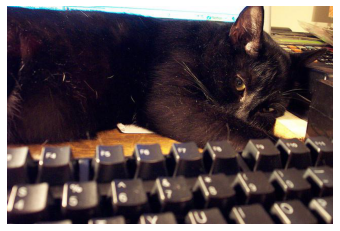

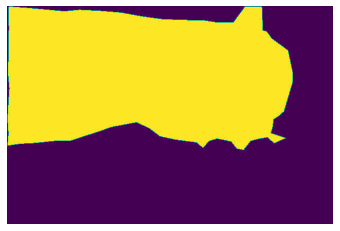

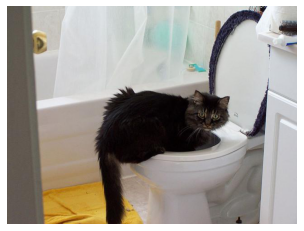

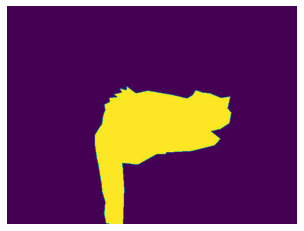

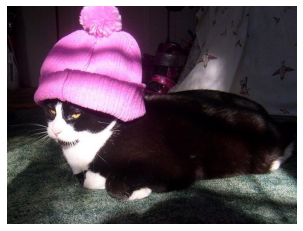

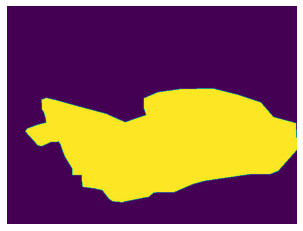

In [8]:
# Visualisation of input data

for num_of_id in range(3):
    img = io.imread(DATA_DIR + f'img_{num_of_id}')
    mask = io.imread(DATA_DIR + f'mask_{num_of_id}')
    mask = mask[:,:,0]/255
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    plt.axis('off')
    plt.imshow(mask)
    plt.show()

In [9]:
def make_grid(shape, window=256, min_overlap=32):
    """
        Return Array of size (N,4), where N - number of tiles,
        2nd axis represente slices: x1,x2,y1,y2 
    """
    x, y = shape
    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num=nx, endpoint=False, dtype=np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num=ny, endpoint=False, dtype=np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    slices = np.zeros((nx,ny, 4), dtype=np.int64)
    
    for i in range(nx):
        for j in range(ny):
            slices[i,j] = x1[i], x2[i], y1[j], y2[j]    
    return slices.reshape(nx*ny,4)

In [10]:
WINDOW=128 # approximate size of cell from image
MIN_OVERLAP=16 # overlaping of cells
NEW_SIZE=128 # new size of cell after resizing.
NUMBER_OF_SAMPLES = 1480

#resizing of input cell from image.
trfm = A.Compose([
    A.Resize(NEW_SIZE,NEW_SIZE),
])

In [11]:
class CoCoDataset(D.Dataset):
    '''
    Датасет для тренировки. Совокупность пар изображений и масок. Изображения
    и маски делятся сеткой, далее они приводятся к одному и тому же размеру 128*128, после
    чего нормализуются.
    '''
    def __init__(self, root_dir, transform,
                 window=256, overlap=32, threshold=0.25, number_of_samples = NUMBER_OF_SAMPLES):  
        self.path = root_dir  # папка
        self.overlap = overlap  # перекрытие плиток
        self.window = window  # размер окна
        self.transform = transform   # трансформации изображения (как минимум изменение размеров)
        self.threshold = threshold  # для отбрасывания плиток без кошки
        self.build_slices()
        self.len = len(self.slices)
        self.as_tensor = T.Compose([
            T.ToTensor(),
            T.Normalize([0.625, 0.448, 0.688],
                        [0.131, 0.177, 0.101]),
        ])
    def build_slices(self):
        '''Получение частей изображения и маски. При этом отбрасываются части,
        на которых нет кота или его очень мало'''
        self.masks = [] # массив с масками. [id_of_image][h][w]
        self.slices = [] # массив со срезами [id_of_slice][4] (x1,x2,y1,y2)
        for num_of_id in range(NUMBER_OF_SAMPLES):
            mask = io.imread(self.path + f'mask_{num_of_id}')
            mask = mask[:,:,0]/255 # полная нормированная маска (числа [0, 1])
            self.masks.append(mask)

            slices = make_grid(mask.shape, window=self.window,
                                min_overlap=self.overlap) 
            for slc in slices:
                x1,x2,y1,y2 = slc
                if mask[x1:x2,y1:y2].sum() > self.threshold:
                    self.slices.append([num_of_id,x1,x2,y1,y2])
                        
    # get data operation
    def __getitem__(self, index):
        '''получение частей изображения и маски '''
        # index - это индекс среза, то есть "номер плитки"!
        num_of_id = self.slices[index][0]
        x1,x2,y1,y2 = self.slices[index][1:]
        img = io.imread(self.path + f'img_{num_of_id}')
        image = img[x1:x2,y1:y2].copy()       
        mask = self.masks[num_of_id][x1:x2,y1:y2]       
        augments = self.transform(image=image, mask=mask)
        #return image, mask
        return self.as_tensor(augments['image']), augments['mask'][None] #??????????????????
    
    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len
    

In [12]:
# visualisation of shapes
train = CoCoDataset(DATA_DIR, window=WINDOW, overlap=MIN_OVERLAP, transform=trfm)

# img, mask = train[0]
# print(img.shape)
# print(mask.shape)
# len(train.slices)

torch.Size([3, 128, 128])
(1, 128, 128)


18799

In [13]:
# Делаем валидационный набор valid_idx
valid_idx, train_idx = [], []
for i in range(NUMBER_OF_SAMPLES):
    if train.slices[i][0] % 4 == 0: # отбор всех плиток, относящейся к каждой 4-ой картинке в валидационный датасет
        valid_idx.append(i)
    else:
        train_idx.append(i)


In [14]:
EPOCHES = 3
BATCH_SIZE = 5

In [15]:
## Определяем загрузчики
train_ds = D.Subset(train, train_idx)
valid_ds = D.Subset(train, valid_idx)
# тренировочный
loader = D.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
# валидационный
vloader = D.DataLoader(
    valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

## NETWORK

In [16]:
# Модель
def get_model():
    ENCODER = 'se_resnext50_32x4d'
    ENCODER_WEIGHTS = 'imagenet'
    CLASSES_NUMBER = 1
    ACTIVATION = 'sigmoid'  # could be None for logits or 'softmax2d' for multicalss segmentation

    # create segmentation model with pretrained encoder
    model = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=ENCODER_WEIGHTS,
        classes=CLASSES_NUMBER,
        activation=ACTIVATION,
    )

    return model

In [17]:
# Наша сеть
model = get_model()
# отправка на видеокарту
model.to(DEVICE)
print('Model was successfully sent to GPU')

Successfully sent to GPU


## TRAINER

In [18]:
# Функция для валидации 
@torch.no_grad()
def validation(model, loader, loss_fn):
    losses = []
    model.eval()
    for image, target in loader:
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        output = model(image)
        loss = loss_fn(output, target)
        losses.append(loss.item())
        
    return np.array(losses).mean()

In [19]:
# оптимизатор.
optimizer = torch.optim.AdamW(model.parameters(),
                  lr=1e-4, weight_decay=1e-3)

In [20]:
# LOSS function
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2,-1)):

        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims
    
    def forward(self, x, y):

        tp = (x * y).sum(self.dims)
        fp = (x * (1 - y)).sum(self.dims)
        fn = ((1 - x) * y).sum(self.dims)
        
        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)
        dc = dc.mean()

        return 1 - dc
    
class SoftDiceBCEWithLogitsLoss:
    def __init__():
        self.bce_fn = nn.BCEWithLogitsLoss()
        self.dice_fn = SoftDiceLoss()
    
    def __call__(y_pred, y_true):
        self.bce = bce_fn(y_pred, y_true)
        self.dice = dice_fn(y_pred.sigmoid(), y_true)
        return 0.8*bce+ 0.2*dice
    
    
bce_fn = nn.BCEWithLogitsLoss()
dice_fn = SoftDiceLoss()

def loss_fn(y_pred, y_true):
    bce = bce_fn(y_pred, y_true)
    dice = dice_fn(y_pred.sigmoid(), y_true)
    return 0.8*bce+ 0.2*dice


## Training process

In [31]:
### Table for results
header = r'''
        Train | Valid
Epoch |  Loss |  Loss | Time, m
'''
#          Epoch         metrics            time
raw_line = '{:6d}' + '\u2502{:7.3f}'*2 + '\u2502{:6.2f}'
epoches_passed = 0
# Для графиков
writer = SummaryWriter('statistic_tensorboard')
DEVICE

device(type='cuda', index=0)

In [32]:
'''Обучение происходило итерациями по 3 эпохи, чтобы выбрать лучшую по параметрам сеть, 
ну и избежать перегрева компьютера'''
print(header)
# Общее число батчей
number_batches = len(train_ds)//BATCH_SIZE

# Тренировка
for epoch in range(1, EPOCHES+1):
    losses = []
    start_time = time.time()
    model.train()
    n_iter = 0
    for image, target in loader:
        image, target = image.to(DEVICE), target.float().to(DEVICE)
       
        optimizer.zero_grad()  # обнуление градиента
        output = model(image)  # получение предсказания
        loss = loss_fn(output, target) # вычисление ошибки
        loss.backward()  # вычисление градиентов
        optimizer.step()  # обновление весов
        n_iter += 1
        if n_iter % 10 == 0:
            print(f'batches: {n_iter}/{number_batches}', end='\r')
        
        losses.append(loss.item()) # сохранение ошибки
        writer.add_scalar('Loss/train', loss.item(), n_iter)
    print(f'batches: {number_batches}/{number_batches}')
    vloss = validation(model, vloader, loss_fn) # валидация
    writer.add_scalar('Loss/val', vloss, n_iter)
    print()
    print(raw_line.format(epoch, np.array(losses).mean(), vloss,
                              (time.time()-start_time)/60**1))
    losses = []
epoches_passed += 3
# Сохранение модели
DIR_OF_MODEL = 'CatPytorchModel'
name_model = 'model'
if not os.path.exists(DIR_OF_MODEL):
    os.mkdir(DIR_OF_MODEL)
if os.path.exists(DIR_OF_MODEL + '/' + name_model + str(epoches_passed)):
    os.remove(DIR_OF_MODEL + '/' + name_model + str(epoches_passed))

torch.save(model.state_dict(), DIR_OF_MODEL + '/' + name_model + str(epoches_passed))
print('Model was saved in' + DIR_OF_MODEL + '/' + name_model + str(epoches_passed))


        Train | Valid
Epoch |  Loss |  Loss | Time, m

batches: 212/212

     1│  0.684│  0.657│  0.41
Model was saved inCatPytorchModel/model3


## CONSERVATION OF MODEL

In [21]:
### Сохранение лучшей модели модели
DIR_OF_MODEL = 'CatPytorchModel'
name_model = 'base_model'
if not os.path.exists(DIR_OF_MODEL):
    os.mkdir(DIR_OF_MODEL)
if os.path.exists(DIR_OF_MODEL + '/' + name_model):
    os.remove(DIR_OF_MODEL + '/' + name_model)

torch.save(model.state_dict(), DIR_OF_MODEL + '/' + name_model)
print('Model was saved in' + DIR_OF_MODEL + '/' + name_model)

Saved


In [33]:
writer.close()